# DiscreteDP Example: Discrete Optimal Growth Model

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

We consider a discretized version of the (deterministic) optimal growth model
discussed in
[http://quant-econ.net/py/dp_intro.html](http://quant-econ.net/py/dp_intro.html).
We provide a class `DiscreteGrowthModel`
that wraps the setup and solution procedures in
the [solution notebook](http://nbviewer.ipython.org/github/QuantEcon/QuantEcon.py/blob/master/solutions/discrete_dp_solutions.ipynb)
for the exercise in the lecture.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP

Consider the following problem:
$$
\begin{aligned}
&\max_{\{c_t\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^t u(c_t) \\
&\ \text{ s.t. }\ k_{t+1} = f(k_t) - c_t,
 \quad \text{$k_0$: given},
\end{aligned}
$$
where
$k_t$ and $c_t$ are the capital stock and consumption at time $t$, respectively,
$u$ is the utility function,
$f$ is the production function, and
$\beta \in (0, 1)$ is the discount factor.

We restrict the utility function $u$ and the production function $f$
to the following classes of functions:
$$
u(c) =
\begin{cases}
\frac{c^{1-\rho} - 1}{1 - \rho} & \text{if $\rho \neq 1$} \\
\log c & \text{if $\rho = 1$},
\end{cases}
$$
and
$$
f(k) = k^{\alpha}.
$$

In [3]:
class DiscreteGrowthModel(object):
    """
    Class representing the discrete optimal growth model.
    
    Parameters
    ----------
    alpha : scalar(float), optional(default=0.65)
        The parameter in the production function.
    
    beta : scalar(float), optional(default=0.95)
        The discount factor.
    
    rho : scalar(float), optional(default=1)
        The parameter in the utility function.
    
    grid_max : scalar(int), optional(default=2)
        The maximum grid value
    
    grid_size : scalar(int), optional(default=1500)
        The size of grid to use.
    
    """
    def __init__(self, alpha=0.65, beta=0.95, rho=1,
                 grid_max=2, grid_size=1500):
        self.alpha, self.rho = alpha, rho
        self._beta = beta
        self.grid = np.linspace(1e-6, grid_max, grid_size)
        
        C = self.f(self.grid).reshape(grid_size, 1) - \
            self.grid.reshape(1, grid_size)
        s_indices, a_indices = np.where(C > 0)
        R = self.u(C[s_indices, a_indices])
        
        L = len(s_indices)
        data = np.ones(L)
        indptr = np.arange(L+1)
        Q = sparse.csr_matrix((data, a_indices, indptr), shape=(L, grid_size))
        
        self.ddp = DiscreteDP(R, Q, beta, s_indices, a_indices)
        
        self._mc = None
        self.num_iter = None
        
    def f(self, k):
        return k**self.alpha
    
    def u(self, c):
        rho = self.rho
        if rho == 1:
            util = np.log(c)
        else:
            util = (c**(1 - rho) - 1)/(1 - rho)
        return util
        
    @property
    def beta(self):
        return self._beta
    
    @beta.setter
    def beta(self, value):
        self._beta = value
        self.ddp.beta = self._beta
        self._mc = None
        self.num_iter = None
        
    def solve(self, w=None, *args, **kwargs):
        """
        Solve the discrete dynamic programming problem.
        
        """
        res = self.ddp.solve(v_init=w, *args, **kwargs)
        v = res.v
        c = self.sigma_to_c(res.sigma)
        self._mc = res.mc
        self.num_iter = res.num_iter
        return v, c
    
    def sigma_to_c(self, sigma):
        return self.f(self.grid) - self.grid[sigma]
    
    @property
    def mc(self):
        if self._mc is None:
            self.solve()
        return self._mc
    
    def generate_k_path(self, ts_length, k_init=None):
        """
        Generate a trajectory of the capital stock.
        
        """
        if k_init is None:
            k_init_ind = 0
        else:
            k_init_ind = np.searchsorted(self.grid, k_init)
        k_path_ind = self.mc.simulate(ts_length, init=k_init_ind)
        k_path = self.grid[k_path_ind]
        return k_path
    
    def bellman_operator(self, w, compute_policy=False):
        if compute_policy:
            sigma = np.empty(self.ddp.num_states, dtype=int)
            Tw = self.ddp.bellman_operator(w, sigma=sigma)
            c = self.sigma_to_c(sigma)
            return Tw, c
        else:
            Tw = self.ddp.bellman_operator(w)
            return Tw
        
    def compute_greedy(self, w):
        _, c = self.bellman_operator(w, compute_policy=True)
        return c

In [4]:
# Exact solution of the continuous version
alpha, beta = 0.65, 0.95
ab = alpha * beta
c1 = (np.log(1 - ab) + np.log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)
def v_star(k):
    return c1 + c2 * np.log(k)

def c_star(k):
    return (1 - ab) * k**alpha

Convergence of value iteration:

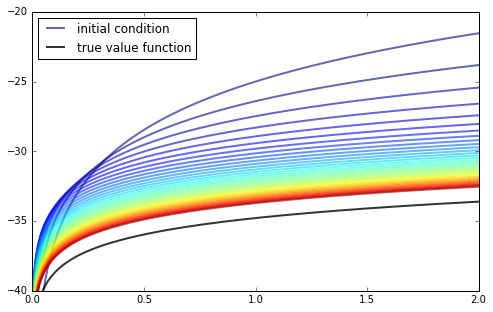

In [5]:
dgm = DiscreteGrowthModel()

w = 5 * np.log(dgm.grid) - 25  # Initial condition
n = 35
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim(-40, -20)
ax.set_xlim(np.min(dgm.grid), np.max(dgm.grid))
lb = 'initial condition'
ax.plot(dgm.grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = dgm.bellman_operator(w)
    ax.plot(dgm.grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
lb = 'true value function'
ax.plot(dgm.grid, v_star(dgm.grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='upper left')

plt.show()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            6.924e+00      1.283e-02         
2            4.107e+00      2.540e-02         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            6.924e+00      1.333e-02         
2            4.107e+00      2.541e-02         
3            3.866e+00      3.903e-02         
4            3.673e+00      5.133e-02         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            6.924e+00      1.392e-02         
2            4.107e+00      2.608e-02         
3            3.866e+00      3.819e-02         
4            3.673e+00      5.178e-02         
5            3.489e+00      6.524e-02         
6            3.315e+00      7.749e-02         


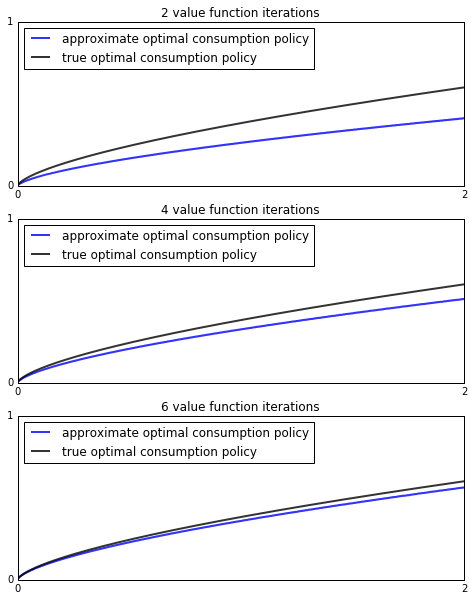

In [6]:
dgm = DiscreteGrowthModel()

fig, ax = plt.subplots(3, 1, figsize=(8, 10))

for i, n in enumerate((2, 4, 6)):
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 2)
    ax[i].set_yticks((0, 1))
    ax[i].set_xticks((0, 2))

    w = 5 * dgm.u(dgm.grid) - 25  # Initial condition
    compute_fixed_point(dgm.bellman_operator, w, max_iter=n, print_skip=1)
    c = dgm.compute_greedy(w)

    ax[i].plot(dgm.grid, c, 'b-', lw=2, alpha=0.8,
               label='approximate optimal consumption policy')
    ax[i].plot(dgm.grid, c_star(dgm.grid), 'k-', lw=2, alpha=0.8,
               label='true optimal consumption policy')
    ax[i].legend(loc='upper left')
    ax[i].set_title('{} value function iterations'.format(n))

Dynamics of capital stock:

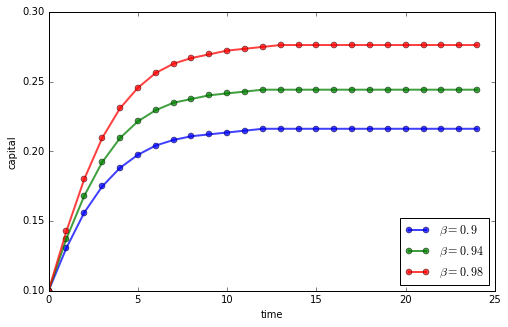

In [7]:
dgm = DiscreteGrowthModel() 
discount_factors = (0.9, 0.94, 0.98)
series_length = 25
k_init = 0.1

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("capital")
ax.set_ylim(0.10, 0.30)

for beta in discount_factors:
    dgm.beta = beta
    k = dgm.generate_k_path(ts_length=series_length, k_init=k_init)
    ax.plot(k, 'o-', lw=2, alpha=0.75, label=r'$\beta = {}$'.format(beta))

ax.legend(loc='lower right')
plt.show()